In [23]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import scipy.stats as stats
import statsmodels.api as sm
import scipy.stats as stats 
from scipy.stats import pearsonr, spearmanr
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
from statannotations.Annotator import Annotator
import create_dataset
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.figure import figaspect
import matplotlib as mpl
%matplotlib inline

In [31]:
import sklearn
python.__version__

NameError: name 'python' is not defined

In [3]:
path_data = "../data/"
savedir = "../output/"
path_samples = path_data + "single_events_data/"
metadata = pd.read_csv(path_data + "Metadata.csv")
measures = pd.read_excel(path_data + "phenotypes.xlsx")
retrain=False

In [4]:
### load syntof
df, markers = create_dataset.createDataset(metadata, path_samples)
markers_names = [it.split("_")[1] for it in markers ]
print(len(markers))

30


In [5]:
df

,Event #,89Y_EAAT1_(Y89Di),113In_VMAT2_(In113Di),115In_Synaptobrevin2_(In115Di),141Pr_LRRK2_(Pr141Di),142Nd_a-Synuclein_(Nd142Di),143Nd_GFAP_(Nd143Di),144Nd_PARKIN_(Nd144Di),146Nd_Casp3_Acti_(Nd146Di),147Sm_BIN1_(Sm147Di),...,170Er_GAMT_2_(Er170Di),171Yb_LC3B_(Yb171Di),173Yb_APP_(Yb173Di),174Yb_K48-Ubiquitin_(Yb174Di),176Lu_SLC6A8_(Lu176Di),filename,Diet,Subject_name,Sample_name,Cohort
0,1,0.039773,0.000000,0.000000,0.373926,0.286259,0.000000,0.000000,0.000000,0.498515,...,0.000000,0.228641,0.000000,0.000000,0.000000,c01_2022_SynTOF2_Mk-LatTempCtx_BC009_FluiXT_Co...,mediterranean,8398,c01_BC009_8398,batch1
1,2,0.170145,0.024200,0.192687,0.655436,1.091951,0.000000,0.098567,0.183583,2.007977,...,0.610055,0.619972,0.397481,0.907191,0.000000,c01_2022_SynTOF2_Mk-LatTempCtx_BC009_FluiXT_Co...,mediterranean,8398,c01_BC009_8398,batch1
2,3,0.000000,0.447064,0.000000,0.000000,0.494881,1.360826,0.000000,0.419558,0.276471,...,0.057982,0.193165,1.201802,0.000000,0.000000,c01_2022_SynTOF2_Mk-LatTempCtx_BC009_FluiXT_Co...,mediterranean,8398,c01_BC009_8398,batch1
3,4,0.111267,0.213933,0.000000,0.634774,0.714131,0.251863,0.000000,0.386929,0.639893,...,0.000000,0.908125,0.118230,0.554488,0.000000,c01_2022_SynTOF2_Mk-LatTempCtx_BC009_FluiXT_Co...,mediterranean,8398,c01_BC009_8398,batch1
4,5,0.104487,0.017022,0.000000,0.055894,0.659700,0.000000,0.000000,0.000000,0.561837,...,0.006407,0.404683,0.314272,0.220298,0.000000,c01_2022_SynTOF2_Mk-LatTempCtx_BC009_FluiXT_Co...,mediterranean,8398,c01_BC009_8398,batch1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51600,51601,0.682555,0.319722,0.435118,0.058370,0.258708,0.092320,0.000000,0.000000,0.239759,...,0.031521,0.353219,0.000000,0.061705,0.317472,c20_2022_SynTOF2_Mk-LatTempCtx_BC010_FluiXT_Co...,Techanical Control 2,TC102,c20_BC010_TC102,batch2
51601,51602,0.000000,0.000000,0.019848,0.521240,0.278492,0.000000,0.000000,0.133769,0.244967,...,0.046993,0.000000,0.000000,0.486151,0.000000,c20_2022_SynTOF2_Mk-LatTempCtx_BC010_FluiXT_Co...,Techanical Control 2,TC102,c20_BC010_TC102,batch2
51602,51603,0.000000,0.000000,0.139854,0.000000,0.459078,0.000000,0.000000,0.000000,0.259407,...,0.012879,0.373518,0.166948,0.000000,0.000000,c20_2022_SynTOF2_Mk-LatTempCtx_BC010_FluiXT_Co...,Techanical Control 2,TC102,c20_BC010_TC102,batch2
51603,51604,0.000000,0.086325,0.486212,0.333002,0.706389,0.146496,0.134527,0.629155,0.000000,...,0.117102,0.824416,1.116897,0.000000,0.000000,c20_2022_SynTOF2_Mk-LatTempCtx_BC010_FluiXT_Co...,Techanical Control 2,TC102,c20_BC010_TC102,batch2


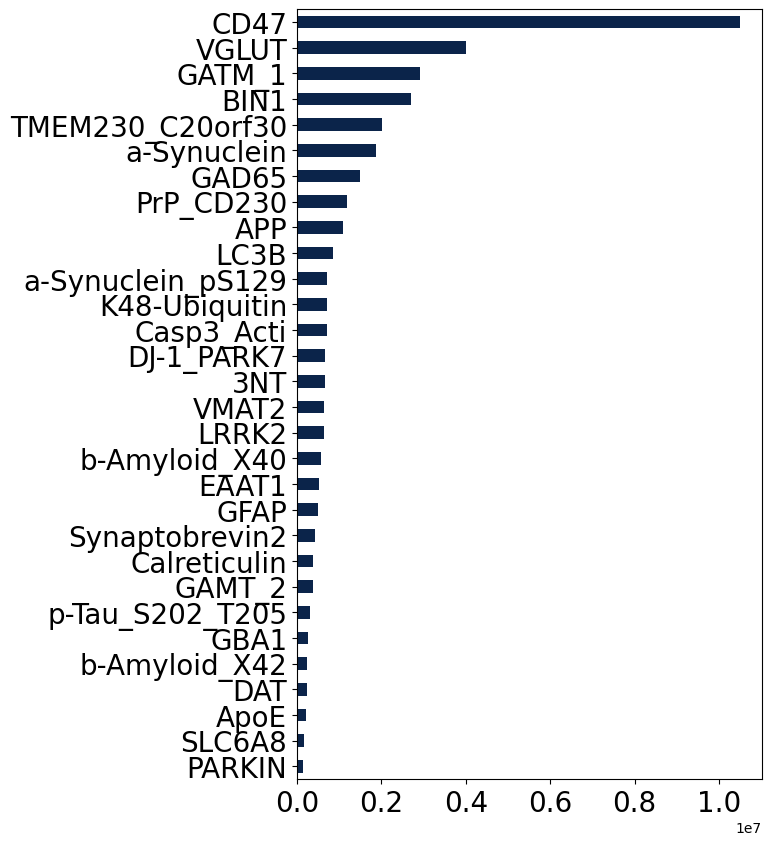

In [6]:
fig,ax= plt.subplots(figsize=(6,10))
df[markers].sum().sort_values().T.plot(kind="barh", color="#0b244a", ax=ax,fontsize=20)
newlab= [it.get_text().split("_(")[0].split("_",1)[1] for it in ax.get_yticklabels()]
ax.set_yticklabels(newlab)
plt.savefig(savedir + "Supp Fig1.svg")
plt.show()  

In [7]:
#Get mean expression
df_mean = df[markers + ["Subject_name","Sample_name"]]
df_mean = df_mean.groupby(["Subject_name","Sample_name"]).mean()
df_mean = df_mean.reset_index()

map_id2diet = {ii:dt for ii,dt in list(zip(measures["ID"].astype(str).values,
                                            measures["Diet"].values))}
df_mean["Diet2"] = df_mean["Subject_name"].astype(str).map(map_id2diet).values
map_id2sg = {ii:dt for ii,dt in list(zip(measures["ID"].astype(str).values,
                                            measures["Treatment_MeanRelRank"].values))}

df_mean["Treatment_MeanRelRank"] = df_mean["Subject_name"].astype(str).map(map_id2sg).values
#col_info = pd.read_excel(path_data + "measures/columns_information.xlsx")

#col_info #= col_info.loc[:,(col_info.sum(0)!=0)]
measures["ID"] = measures["ID"].astype(str)
measures = measures[measures.ID.isin(df.Subject_name.unique().tolist())]
measures

,ID,Diet,Status,Hemisphere_Frozen,Nx_Time,Treatment_MeanRelRank,TM31_BMI,TM26_INS_AUC_10-40,T28_VMmeanAct,TM27.31_CalsConsumed,...,TBV_PC,Mean_Peak_Prog_exp,Mean_cycle_Length_exp,TM28_LATENCY_6PM-6AM,TM28_TOT_SLP_TM_6PM-6AM,TM28_NUM_AWKNINGS_6PM-6AM,X13_24_TOT%H,X13_24_TOT%B,X13_24_TOT%D,X13_24_TOT%anxiety
0,8358,1,Dominant,L,AM,0.691290,44.849537,5829.709992,11372.641667,344.137500,...,-1.217277,14.83008,26.42857,5,693,12,45.598958,2.714583,0.000000,26.684375
1,8359,2,Subordinate,L,AM,0.500000,30.236286,1323.519999,22691.145833,233.404444,...,0.164770,16.58319,33.70000,11,648,11,19.008333,40.348958,10.163542,19.559375
2,8360,1,Subordinate,L,AM,0.362903,73.673257,28939.850000,21594.016667,414.222353,...,3.426442,3.39994,43.50000,31,639,6,57.355208,5.639583,0.000000,10.878125
3,8361,1,Dominant,L,AM,1.000000,35.142171,5872.179995,17281.550000,187.094118,...,0.405785,6.42678,25.71429,16,524,34,60.388542,4.576042,0.038542,27.255208
4,8362,1,Dominant,R,PM,0.978710,42.386831,601.140001,17054.091667,220.288235,...,2.010228,22.11633,32.72727,7,685,16,36.898958,11.947917,0.432292,21.703125
5,8363,1,Dominant,R,PM,1.000000,51.632785,3765.679997,28604.858333,248.654118,...,2.731129,22.63295,31.90909,29,641,11,50.981250,2.103125,0.818750,11.473958
6,8364,2,Dominant,L,AM,1.000000,37.591827,1896.719999,5889.975000,217.697778,...,0.207534,11.54980,27.30769,0,699,5,16.885417,57.727083,0.119792,14.012500
7,8365,2,Subordinate,L,AM,0.032258,37.547881,1058.700001,7653.937500,208.915556,...,-1.673127,17.00218,30.18182,0,631,22,22.287500,57.518750,2.835417,41.421875
8,8366,1,Dominant,R,AM,0.615161,37.961532,1713.670000,25101.783333,312.628235,...,0.890160,7.90964,30.66667,16,622,13,36.494792,0.765625,0.000000,8.930208
10,8368,1,Subordinate,R,AM,0.000000,42.604143,1486.479999,10970.562500,234.370588,...,1.526419,18.05279,25.00000,10,568,29,45.844792,14.707292,1.506250,23.822917


In [8]:
#henotypes variables
col_det = measures.iloc[:,:15].columns.tolist()
col_det

['ID',
 'Diet',
 'Status',
 'Hemisphere_Frozen',
 'Nx_Time',
 'Treatment_MeanRelRank',
 'TM31_BMI',
 'TM26_INS_AUC_10-40',
 'T28_VMmeanAct',
 'TM27.31_CalsConsumed',
 'TM27.31_CalsperKg',
 'TM28_GaitSpeed',
 'TM27_LiverAttn',
 'TM27_PercFat',
 'TM29_AcuteStress_AUC']

In [9]:
## Derived anndat object
df = df[df.Subject_name.isin(measures.ID.unique().tolist())]
df
df = df.merge(measures.iloc[:, :10], left_on="Subject_name", right_on="ID")

adata = ad.AnnData(df[markers])
adata.var["marker"] = markers
adata.var["marker_name"] = markers_names
columns_it = [it for it in df.columns if not it in markers]
for it in columns_it:
    adata.obs[it] = df[it].values
adata



/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 3321410 × 30
    obs: 'Event #', 'filename', 'Diet_x', 'Subject_name', 'Sample_name', 'Cohort', 'ID', 'Diet_y', 'Status', 'Hemisphere_Frozen', 'Nx_Time', 'Treatment_MeanRelRank', 'TM31_BMI', 'TM26_INS_AUC_10-40', 'T28_VMmeanAct', 'TM27.31_CalsConsumed'
    var: 'marker', 'marker_name'

In [10]:
#covariates
tot = []
for label in [ "Nx_Time", 'Hemisphere_Frozen', "Treatment_MeanRelRank"] :
    df
    df_mean = df[markers + ["Subject_name","Sample_name"]]
    map_id2diet = {ii:dt for ii,dt in list(zip(df["Subject_name"].values,
                                                df[label].values))}
    df_mean = df_mean.groupby(["Subject_name","Sample_name"]).mean()
    df_mean = df_mean.reset_index()
    df_mean[label] = df_mean["Subject_name"].map(map_id2diet).values
    map_id2status = {ii:dt for ii,dt in list(zip(df["Subject_name"].values,
                                                df["Status"].values))}
    df_med = df_mean[df_mean[label] =="mediterranean"]
    df_wes = df_mean[df_mean[label] =="western"]
    title = "western vs mediterranean"
    if label == "Hemisphere_Frozen":
        df_med = df_mean[df_mean[label] =="L"]
        df_wes = df_mean[df_mean[label] =="R"]
        title = "R vs L"
    elif label == "Nx_Time":
        df_med = df_mean[df_mean[label] =="PM"]
        df_wes = df_mean[df_mean[label] =="AM"]
        title = "AM vs PM"
    elif label == "Status":
        df_med = df_mean[df_mean[label] =="Dominant"]
        df_wes = df_mean[df_mean[label] =="Subordinate"]
        title = "AM vs PM"
    elif label=="Treatment_MeanRelRank":
        df_m = df_mean.loc[:, label].to_numpy()
    df_DE = pd.DataFrame(columns=["marker", "pval", "FC"])
    for col in markers:
        if label != "Treatment_MeanRelRank":
            med1 = df_med.loc[:, col].to_numpy()
            wes1 = df_wes.loc[:, col].to_numpy()
            fc = np.log2(med1.mean()/(wes1.mean() + 1e-7))
            if np.isnan(fc):
                fc = 0
            _, pval = stats.mannwhitneyu(med1, wes1)

            #print(pval)
        else:
            gg = df_mean.loc[:, col].to_numpy()
            fc, pval = spearmanr(gg, df_m)
        df_DE.loc[len(df_DE),:] = [col, pval, fc]
    _, q_value = sm.stats.fdrcorrection(df_DE.pval.values,
                                    is_sorted=False)
    df_DE["qvalue"] = -np.log(q_value.astype(float))
    df_DE["covariate"] = label
    tot.append(df_DE)
tot = pd.concat(tot)
tot

,marker,pval,FC,qvalue,covariate
0,89Y_EAAT1_(Y89Di),0.199318,-0.117504,0.160854,Nx_Time
1,113In_VMAT2_(In113Di),0.676579,0.030865,0.090312,Nx_Time
2,115In_Synaptobrevin2_(In115Di),0.500416,-0.020074,0.090312,Nx_Time
3,141Pr_LRRK2_(Pr141Di),0.700201,-0.012611,0.090312,Nx_Time
4,142Nd_a-Synuclein_(Nd142Di),0.261412,-0.121998,0.160854,Nx_Time
...,...,...,...,...,...
25,170Er_GAMT_2_(Er170Di),0.858373,-0.030822,0.105845,Treatment_MeanRelRank
26,171Yb_LC3B_(Yb171Di),0.57874,0.095702,0.222371,Treatment_MeanRelRank
27,173Yb_APP_(Yb173Di),0.191893,0.222615,0.222371,Treatment_MeanRelRank
28,174Yb_K48-Ubiquitin_(Yb174Di),0.974884,-0.005439,0.025437,Treatment_MeanRelRank


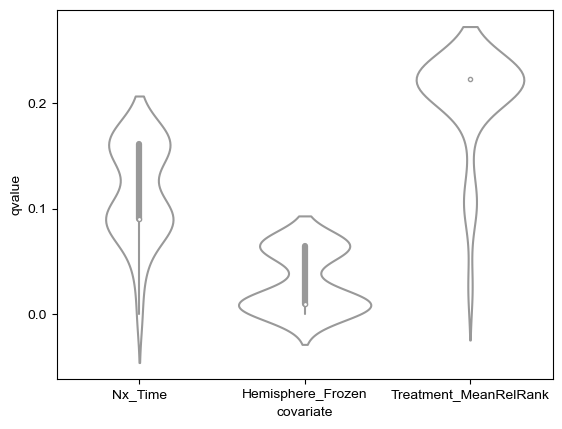

In [32]:
fig, ax = plt.subplots()
sns.set(style="white",font_scale=2)
sns.violinplot(data=tot, x="covariate", y="qvalue", ax=ax, color="white")
# ax.axhline(y=-np.log(0.05), c="red")
# ax.set_yscale("log")
plt.savefig(savedir + "Supp Fig1b.svg")
plt.show()    

# Univariate Analysis (WES/MED)

/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_46399/3969761318.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.05,0.5))


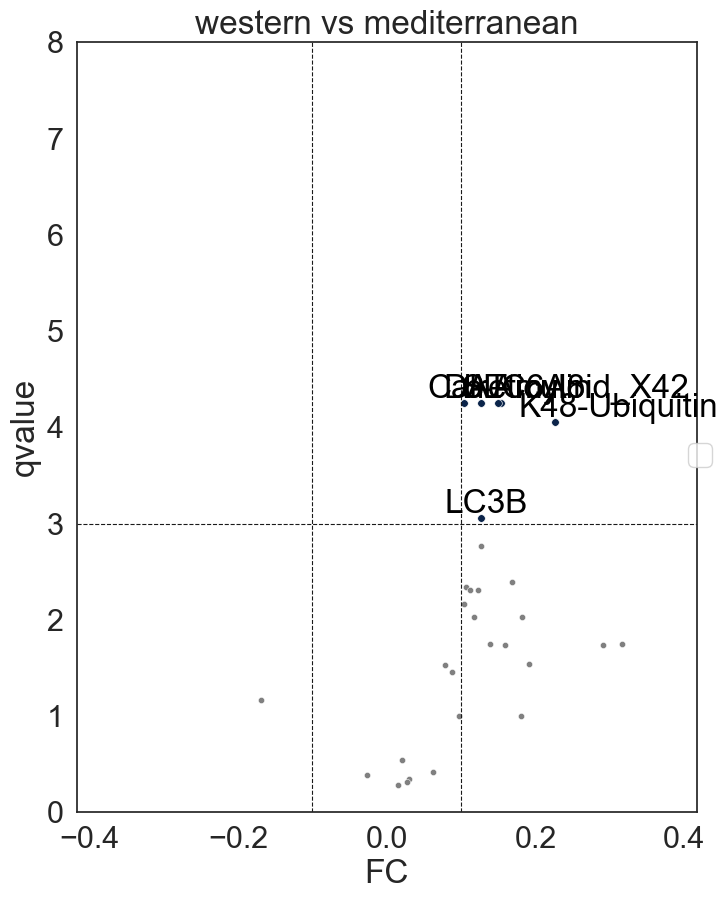

In [12]:
Pval = 0.05
label = "Diet_x"
df
df_mean = df[markers + ["Subject_name","Sample_name"]]
map_id2diet = {ii:dt for ii,dt in list(zip(df["Subject_name"].values,
                                            df[label].values))}
df_mean = df_mean.groupby(["Subject_name","Sample_name"]).mean()
df_mean = df_mean.reset_index()
df_mean[label] = df_mean["Subject_name"].map(map_id2diet).values
# map_id2status = {ii:dt for ii,dt in list(zip(df["Subject_name"].values,
                                            # df["Status"].values))}
df_med = df_mean[df_mean[label] =="mediterranean"]
df_wes = df_mean[df_mean[label] =="western"]
title = "western vs mediterranean"
if label == "Hemisphere_Frozen":
    df_med = df_mean[df_mean[label] =="L"]
    df_wes = df_mean[df_mean[label] =="R"]
    title = "R vs L"
elif label == "Nx_Time":
    print("ok")
    df_med = df_mean[df_mean[label] =="PM"]
    df_wes = df_mean[df_mean[label] =="AM"]
    title = "AM vs PM"
df_DE = pd.DataFrame(columns=["marker", "pval", "FC"])
for col in markers:
    med1 = df_med.loc[:, col].to_numpy()
    wes1 = df_wes.loc[:, col].to_numpy()
    fc = np.log2(med1.mean()/(wes1.mean() + 1e-7))
    if np.isnan(fc):
        fc = 0
    _, pval = stats.mannwhitneyu(med1, wes1)
    
    #print(pval)
    df_DE.loc[len(df_DE),:] = [col, pval, fc]
_, q_value = sm.stats.fdrcorrection(df_DE.pval.values,
                                is_sorted=False)
df_DE["qvalue"] = -np.log(q_value.astype(float))
#df_DE["qvalue"].fillnainf(0, inplace=True)
df.replace([np.inf, -np.inf], 0, inplace=True)

Pval =0.05

FC = 0.1

ylim = -np.log(Pval)
xlim = FC
x = "FC"
y = "qvalue"
jj = df_DE
xmax = np.abs(df_DE[x]).max() +0.1
sns.set(font_scale=2, style="white")

fig, ax = plt.subplots(figsize=(8,10))
jj_s1 = jj[(jj[y] >= ylim) & (jj[x].astype(float) >= xlim)]        
sns.scatterplot(data=jj_s1, x=x, y=y,
                         ax=ax, s=30, color="#0b244a")

jj_s2 = jj[(jj[y] >= ylim) & (jj[x].astype(float) <= -xlim)]        
sns.scatterplot(data=jj_s2, x=x, y=y,
                         ax=ax, s=30, color="#dfb920")
jj_ns = jj[(jj[y] < ylim) | (np.abs(jj[x]) < xlim)]
sns.scatterplot(data=jj_ns, x=x, y=y,  
ax=ax,  color="grey", s=20)
ax.axhline(y=ylim,color= 'k', linestyle='--', linewidth=0.8)
ax.axvline(x=-xlim, color= 'k', linestyle='--', linewidth=0.8)
ax.axvline(x=xlim, color= 'k', linestyle='--', linewidth=0.8)
ax.set_title(title)
ax.set_xlim(-xmax, xmax)
ax.set_ylim(0, 8)

ax.legend(bbox_to_anchor=(1.05,0.5))
if True:
    for line in range(0,jj_s1.shape[0]):
        ax.text(jj_s1[x].iloc[line]-0.05, jj_s1[y].iloc[line]+0.05,
                            jj_s1["marker"].iloc[line].split("_(")[0].split("_",1)[1], 
                            horizontalalignment='left', color='black')
plt.savefig(savedir + "Figure2A.svg", bbox_inches="tight")
plt.show()
plt.close("all")


6
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

western vs. mediterranean: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.706e-03 U_stat=6.200e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

western vs. mediterranean: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.910e-04 U_stat=5.100e+01


/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_46399/1470027555.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_46399/1470027555.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_46399/1470027555.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_46399/1470027555.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose labe

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

western vs. mediterranean: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.900e-03 U_stat=6.300e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

western vs. mediterranean: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.367e-03 U_stat=7.900e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

western vs. mediterranean: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.895e-03 U_stat=6.700e+01
p-value annotation legend

/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_46399/1470027555.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_46399/1470027555.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()


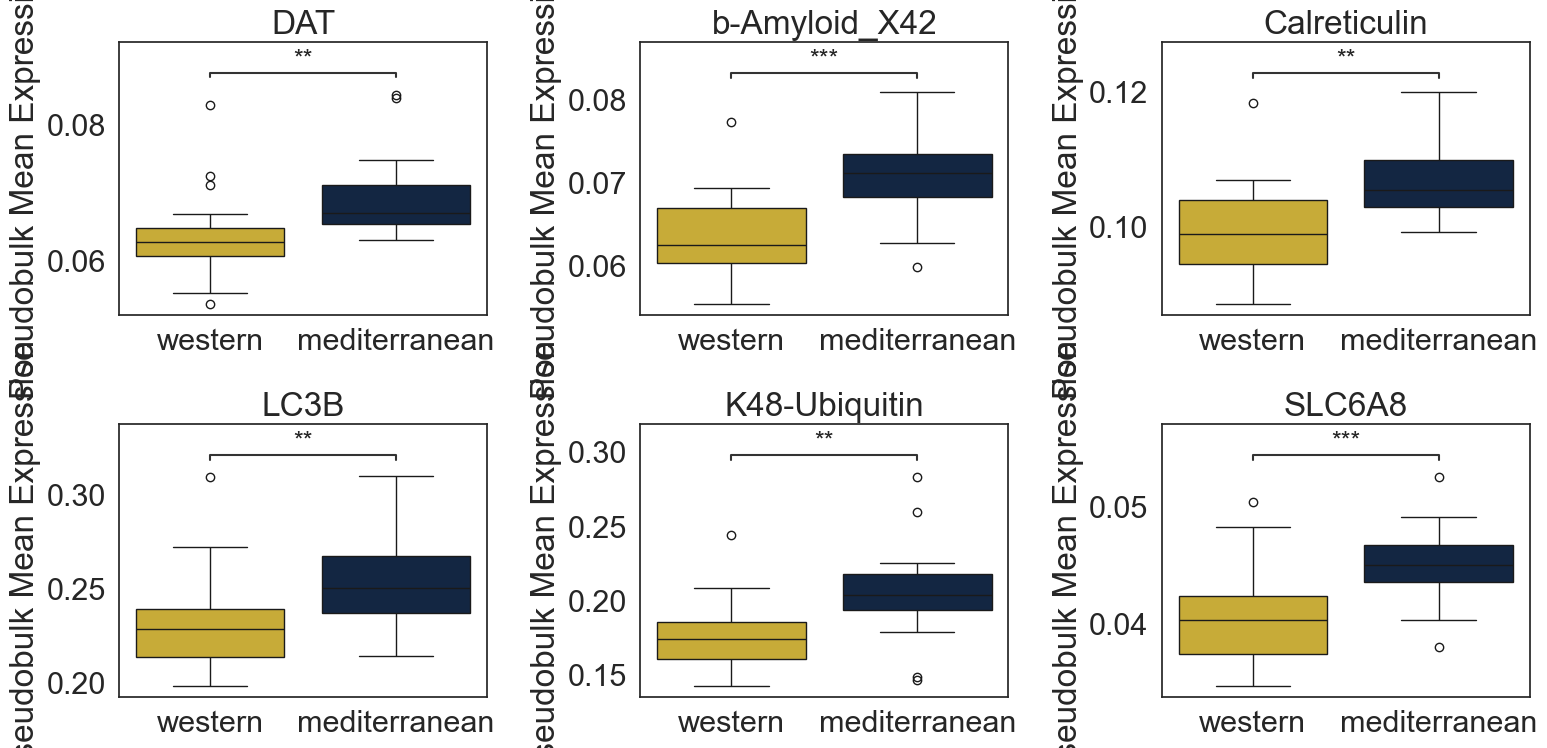

In [16]:
palette= {"mediterranean":"#0b244a", "western":"#dfb920"}
dee = pd.concat([jj_s1, jj_s2])
list_de = dee["marker"].unique().tolist()
print(len(list_de))
#for it in 
sns.set(font_scale=2, style="white")
fig, axes = plt.subplots(2,3, figsize=(16, 8))
axes = axes.flatten()
box_pair = [((df_mean[label].unique().tolist()[0], df_mean[label].unique().tolist()[0]), (df_mean[label].unique().tolist()[1],df_mean[label].unique().tolist()[1]))]
box_pair = [(df_mean[label].unique().tolist()[0],df_mean[label].unique().tolist()[1])]

for ii, it in enumerate(list_de):
    ax = axes[ii]
    sns.boxplot(data=df_mean, x=label, y=it, ax=ax,hue=label, palette=palette)
    annotator = Annotator(ax, box_pair, data=df_mean, x=label, y=it, hue=label)
    annotator.configure(test='Mann-Whitney',  text_format="star", loc='inside', fontsize="18", comparisons_correction="BH")
    annotator.apply_and_annotate()
    ax.set_title(it.split("_(")[0].split("_",1)[1])
    ax.set_ylabel("Pseudobulk Mean Expression")
    ax.set_xlabel("")

    ax.legend().remove()
plt.tight_layout()
plt.savefig(savedir + "Figure2B.svg")
plt.show()    

6
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

western_Dominant vs. mediterranean_Dominant: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.203e-02 U_stat=2.800e+01
western_Subordinate vs. mediterranean_Subordinate: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.324e-03 U_stat=6.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

western_Dominant vs. mediterranean_Dominant: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.832e-02 U_stat=2.100e+01
western_Subordinate vs. mediterranean_Subordinate: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.051e-02 U_stat=8.000e+0

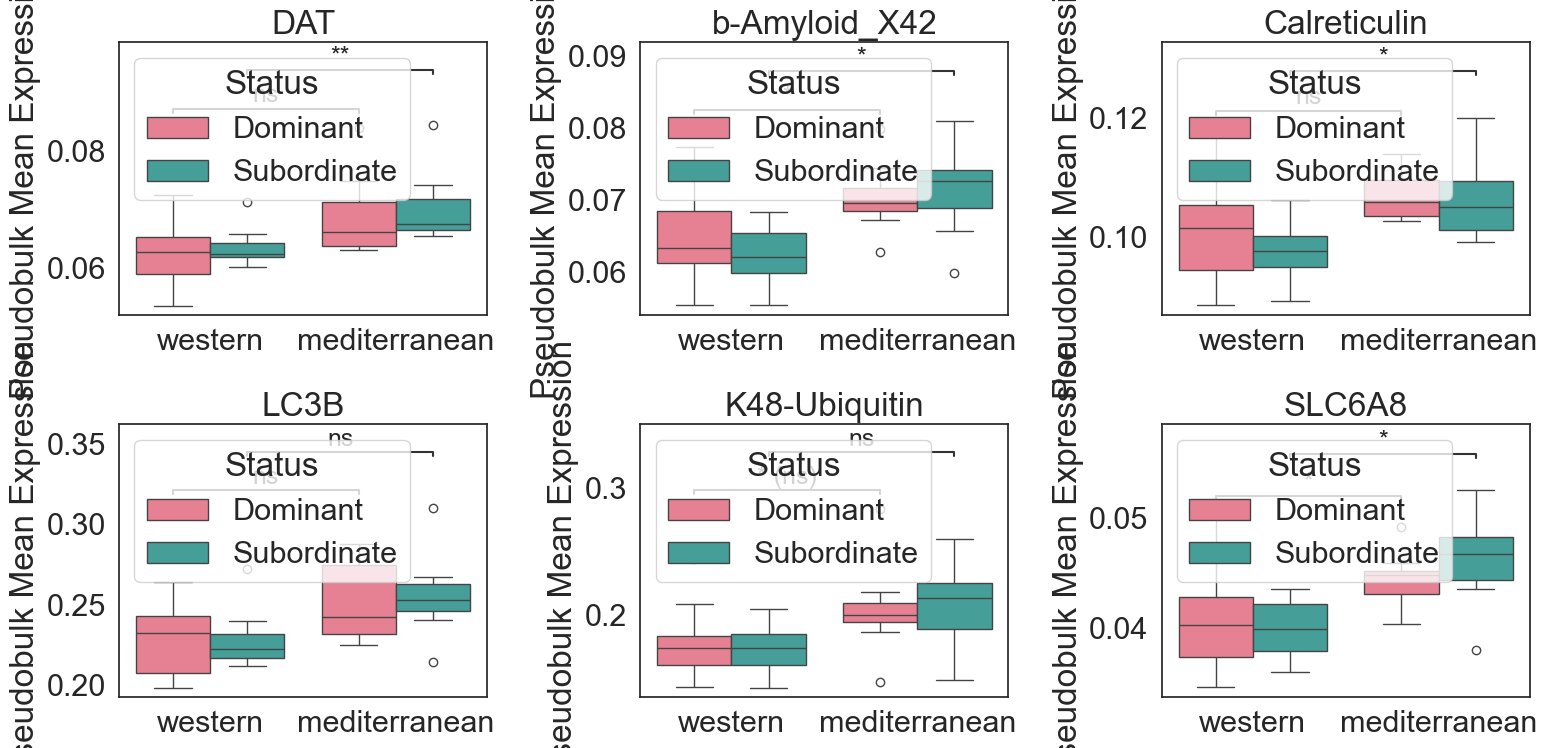

In [17]:
df_mean["Status"] = df_mean["Subject_name"].map(map_id2status).values

palette= {"mediterranean":"#0b244a", "western":"#dfb920"}
palette = "husl"
dee = pd.concat([jj_s1, jj_s2])
list_de = dee["marker"].unique().tolist()
print(len(list_de))
#for it in 
sns.set(font_scale=2, style="white")
fig, axes = plt.subplots(2,3, figsize=(16, 8))
axes = axes.flatten()
box_pair = [((df_mean[label].unique().tolist()[0], df_mean[label].unique().tolist()[0]), (df_mean[label].unique().tolist()[1],df_mean[label].unique().tolist()[1]))]
box_pair = [((df_mean[label].unique().tolist()[0], "Dominant"), (df_mean[label].unique().tolist()[1],"Dominant")),
           ((df_mean[label].unique().tolist()[0], "Subordinate"), (df_mean[label].unique().tolist()[1],"Subordinate")),]

for ii, it in enumerate(list_de):
    ax = axes[ii]
    sns.boxplot(data=df_mean, x=label, y=it, ax=ax,hue="Status", palette=palette)
    annotator = Annotator(ax, box_pair, data=df_mean, x=label, y=it, hue="Status")
    annotator.configure(test='Mann-Whitney',  text_format="star", loc='inside', fontsize="18", comparisons_correction="BH")
    annotator.apply_and_annotate()
    ax.set_title(it.split("_(")[0].split("_",1)[1])
    ax.set_ylabel("Pseudobulk Mean Expression")
    ax.set_xlabel("")

    #ax.get_legend().remove()
plt.tight_layout()
# plt.savefig(savedir + "box_plot_stratified_by_status_%s.svg"%label)
plt.show()    

/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_46399/2010931241.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.05,0.5))


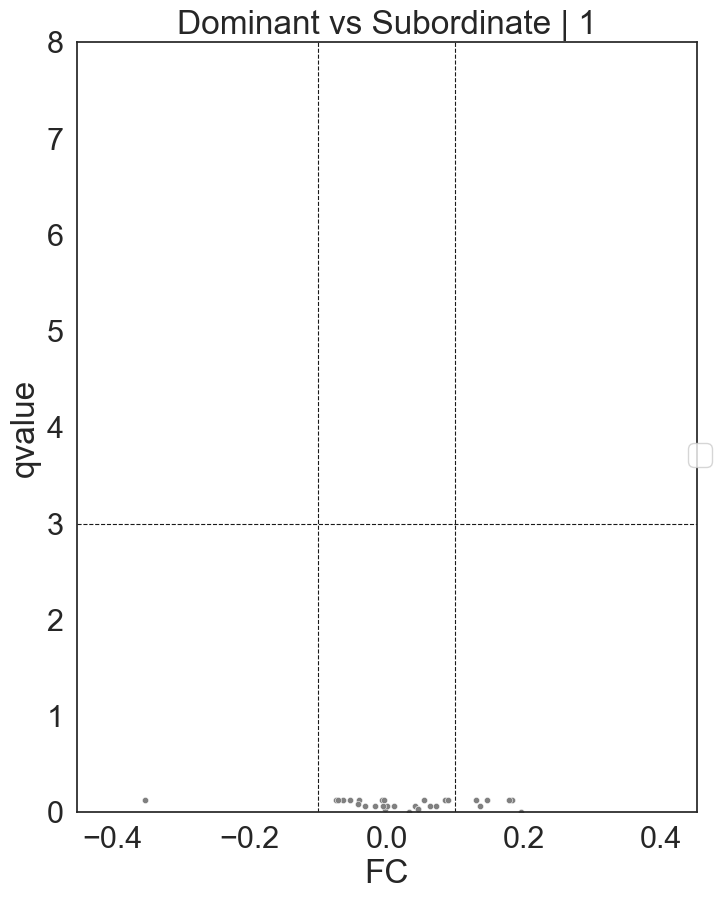

In [18]:
Pval = 0.05
label = "Status"
df
statut = 1
df_mean = df[df.Diet_y == statut]
df_mean = df_mean[markers + ["Subject_name","Sample_name"]]

map_id2diet = {ii:dt for ii,dt in list(zip(df["Subject_name"].values,
                                            df[label].values))}
df_mean = df_mean.groupby(["Subject_name","Sample_name"]).mean()
df_mean = df_mean.reset_index()
df_mean[label] = df_mean["Subject_name"].map(map_id2diet).values
map_id2status = {ii:dt for ii,dt in list(zip(df["Subject_name"].values,
                                            df["Status"].values))}
df_med = df_mean[df_mean[label] =="mediterranean"]
df_wes = df_mean[df_mean[label] =="western"]
title = "western vs mediterranean | %s"%statut
if label == "Hemisphere_Frozen":
    df_med = df_mean[df_mean[label] =="L"]
    df_wes = df_mean[df_mean[label] =="R"]
    title = "R vs L"
elif label == "Status":
    df_med = df_mean[df_mean[label] =="Dominant"]
    df_wes = df_mean[df_mean[label] =="Subordinate"]
    title = "Dominant vs Subordinate | %s"%statut
df_DE = pd.DataFrame(columns=["marker", "pval", "FC"])
for col in markers:
    med1 = df_med.loc[:, col].to_numpy()
    wes1 = df_wes.loc[:, col].to_numpy()
    fc = np.log2(np.abs(med1.mean()/(wes1.mean() + 1e-7)))
    if np.isnan(fc):
        fc = 0
    _, pval = stats.mannwhitneyu(med1, wes1)
    
    #print(pval)
    df_DE.loc[len(df_DE),:] = [col, pval, fc]
_, q_value = sm.stats.fdrcorrection(df_DE.pval.values,
                                is_sorted=False)
df_DE["qvalue"] = -np.log(q_value.astype(float))
#df_DE["qvalue"].fillnainf(0, inplace=True)
df.replace([np.inf, -np.inf], 0, inplace=True)

Pval =0.05

FC = 0.1

ylim = -np.log(Pval)
xlim = FC
x = "FC"
y = "qvalue"
jj = df_DE
xmax = np.abs(df_DE[x]).max() +0.1
sns.set(font_scale=2, style="white")

fig, ax = plt.subplots(figsize=(8,10))
jj_s1 = jj[(jj[y] >= ylim) & (jj[x].astype(float) >= xlim)]        
sns.scatterplot(data=jj_s1, x=x, y=y,
                         ax=ax, s=30, color="#0b244a")

jj_s2 = jj[(jj[y] >= ylim) & (jj[x].astype(float) <= -xlim)]        
sns.scatterplot(data=jj_s2, x=x, y=y,
                         ax=ax, s=30, color="#dfb920")
jj_ns = jj[(jj[y] < ylim) | (np.abs(jj[x]) < xlim)]
sns.scatterplot(data=jj_ns, x=x, y=y,  
ax=ax,  color="grey", s=20)
ax.axhline(y=ylim,color= 'k', linestyle='--', linewidth=0.8)
ax.axvline(x=-xlim, color= 'k', linestyle='--', linewidth=0.8)
ax.axvline(x=xlim, color= 'k', linestyle='--', linewidth=0.8)
ax.set_title(title)
ax.set_xlim(-xmax, xmax)
ax.set_ylim(0, 8)

ax.legend(bbox_to_anchor=(1.05,0.5))
if True:
    for line in range(0,jj_s1.shape[0]):
        ax.text(jj_s1[x].iloc[line]-0.05, jj_s1[y].iloc[line]+0.05,
                            jj_s1["marker"].iloc[line].split("_(")[0].split("_",1)[1], 
                            horizontalalignment='left', color='black')
# plt.savefig(savedir + "Volcano_%s_only_in_%s.svg"%(label,statut), bbox_inches="tight")
plt.show()
plt.close("all")


# Multivariate Analysis

In [19]:

label = "Diet_x"
df
df_mean = df[markers + ["Subject_name","Sample_name"]]
map_id2diet = {ii:dt for ii,dt in list(zip(df["Subject_name"].values,
                                            df[label].values))}
df_mean = df_mean.groupby(["Subject_name","Sample_name"]).mean()
df_mean = df_mean.reset_index()
df_mean[label] = df_mean["Subject_name"].map(map_id2diet).values


In [20]:

X =df_mean[markers].values
y = df_mean[label].map({"mediterranean":1, "western":0}).values
y

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1])

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RepeatedKFold, RepeatedStratifiedKFold, LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd
# from xgboost import XGBClassifier, XGBRegressor
from sklearn.svm import SVC, SVR
from sklearn.linear_model import Ridge, Lasso, ElasticNetCV, ElasticNet
from joblib import parallel_backend
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import wilcoxon, mannwhitneyu, spearmanr
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

models = ['LASSO', 'Ridge', 'EN', 'Random Forest', 'SVM']
res = pd.DataFrame(np.zeros((len(models), 2)), index=models, columns=['AUC', 'P-value'])
y_preds = {k:pd.DataFrame(np.zeros((len(y), 1)), columns=['y_pred']) for k in models}
for algo in models:
    loo = LeaveOneOut()
    loo = RepeatedStratifiedKFold(n_splits =10, n_repeats=50, random_state=0)
    tmp = pd.DataFrame(columns=range(len(X)))
    for train_index, test_index in loo.split(X,y):
        models = {
                    'EN': LogisticRegression(penalty='elasticnet', l1_ratio=0.5, fit_intercept=False, solver='saga', max_iter=10000), #'EN': customLogisticRegressionCV(cv=5, l1_ratios=[0, 0.25, 0.5, 0.75, 1], fit_intercept=False),
                    'LASSO': LogisticRegression(penalty='l1', fit_intercept=False, solver='saga', max_iter=10000), #customLogisticRegressionCV(cv=5, l1_ratios=[1], fit_intercept=False), #
                    'Ridge': LogisticRegression(penalty='l2', fit_intercept=False), #customLogisticRegressionCV(cv=5, l1_ratios=[0], fit_intercept=False), #
                    'Random Forest': RandomForestClassifier(),
                    'KNN': KNeighborsClassifier(),
                    'SVM': SVC(probability=True),  #rbf for AD, linear for LBD
                    # 'XGBoost': XGBClassifier(n/_jobs=-1, booster='gblinear', objective='binary:logistic')
                }
        clf = models[algo]
        pipe = Pipeline([("scale", StandardScaler()),
                  #("reduce_dims", PCA()),
                 ("model", clf)
                 ])
        X_train, X_test = X[train_index, :], X[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        pipe.fit(np.array(X_train), np.array(y_train))
        # if algo in ['LASSO', 'Ridge']:
            # y_pred = np.array(clf.best_estimator_.predict_proba(np.array(X_test))[:, 1])
        # else:
        y_pred = np.array(pipe.predict_proba(np.array(X_test))[:, 1])

        ans_list = [None] * len(X)
        start = 0
        for j in test_index:

            ans_list[j] = y_pred[start]
            start += 1
            tmp.loc[len(tmp),:]=ans_list
            
            # y_preds[name].loc[test_index, :] = y_pred[0]
        y_preds[algo] = tmp.mean(0).values.astype(float).reshape(-1)
        # y_preds[algo].loc[test_index, :] = y_pred
    # evaluation
    res.loc[algo, 'P-value'] = mannwhitneyu(y_preds[algo][y==0], y_preds[algo][y==1]).pvalue
    res.loc[algo, 'AUC'] = roc_auc_score(y, y_preds[algo])
    print(res.loc[algo, 'AUC'])
    print(res.loc[algo, 'P-value'])

0.848297213622291
0.0003866908023672935
0.8606811145510835
0.00023714756097705064
0.8513931888544892
0.00034268566484287505
0.7801857585139319
0.0043461718204953715
0.8854489164086687
8.520953755513624e-05


<>:46: SyntaxWarning: invalid escape sequence '\i'
<>:46: SyntaxWarning: invalid escape sequence '\i'
/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_43358/4158106364.py:46: SyntaxWarning: invalid escape sequence '\i'
  plt.text(0.815, 0.4, '$\it{n=}$' + str(len(y)), fontsize=fontsize)


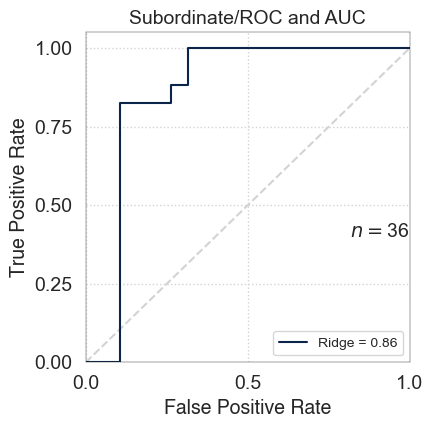

In [57]:
fpr = dict()
tpr = dict()
roc_auc = dict()
gr_truth = y


font = "Arial"
hfont = {'fontname':'Helvetica'}
algo_list = ["Ridge"]
for i, algo in enumerate(algo_list): #):
    fpr[i], tpr[i], _ = roc_curve(gr_truth, np.array(y_preds[algo]))
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.rc('grid', linestyle="dotted", color='lightgray')
color = ['#22162B', '#724E91', '#EE4266', '#f8a530', '#93B5C6']
color = ["#0b244a","#dfb920", "#ababab","#8b0000","#008000"]

#color = 
w, h = figaspect(1.)
plt.figure(figsize=(w, h))
mpl.rcParams['axes.linewidth'] = 0.3
lw = 1.5
fontsize = 14
plt.plot([0, 1], [0, 1], color='lightgrey', lw=lw, linestyle='--')
for i, algo in enumerate(algo_list): #y_preds.keys()):
    tpr[i][0] = 0
    plt.plot(fpr[i], tpr[i], color=color[i], 
            lw=lw, label='{} = {:.2f}'.format(algo, roc_auc[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=fontsize, fontname=font)
plt.yticks(fontsize=fontsize, fontname=font)
plt.xlabel('False Positive Rate', size=fontsize, **hfont)
plt.ylabel('True Positive Rate', size=fontsize, **hfont)
#plt.title('Mediterrannean/ROC and AUC', size=fontsize)
plt.title('Subordinate/ROC and AUC', size=fontsize)
plt.text(0.815, 0.4, '$\it{n=}$' + str(len(y)), fontsize=fontsize)
plt.legend(loc="lower right", fontsize=fontsize-4)
plt.tight_layout()
plt.savefig(savedir + "Figure2C.svg")
plt.grid(True)